# Sesión 06 - Manejo de Modelos de Clasificación para entornos operativos

*Objetivo*

- Aplicar algoritmos de clasificación para identificar eventos operacionales críticos en la industria petrolera.
- Evaluar el rendimiento de diferentes clasificadores.
- Interpretar los resultados y la matriz de confusión.
- Analizar la eficiencia en pozos productores.

In [3]:
!python --version


Python 3.12.1


## 0. Carga de Librerías

In [4]:
# Instalación de dependencias del nuevo codespace
!pip install -r ../requirements.txt

In [5]:
# Importación de Librerías
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Modelamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix # Modelos de Clasificación
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_squared_error # Modelos de Regresión

## 1. Carga de Datos

In [6]:
# Carga desde la carpeta data/raw/

# Ruta Absoluta en Linux o Mac
df = pd.read_csv("/workspaces/ml-bootcamp-labs/data/raw/Operational_events.csv")


In [7]:
df

,Well_ID,Date,Time,Pressure,Temperature,Flow_Rate,Pump_Speed,Gas_Oil_Ratio,Water_Cut,Vibration,Event_Type,Maintenance_Required,Downtime
0,7.0,2023-12-15,14:42:07,3394.633937,131.203728,155.994520,174.250837,1326.028990,0.601115,7.080726,Normal,0.0,0.000000
1,2.0,2023-12-10,11:29:37,1003.115063,298.442312,617.481510,1834.959481,NaN,0.023062,5.247747,Normal,0.0,0.000000
2,16.0,2023-09-28,14:50:43,3056.937754,218.482914,46.450413,1822.634556,421.681361,NaN,9.488855,Blockage,1.0,59.737430
3,9.0,2023-12-12,20:01:19,1964.101864,236.652704,609.996658,2499.584735,425.374050,0.391061,1.822361,Normal,0.0,0.000000
4,6.0,2023-02-23,09:03:53,1125.253170,268.456955,449.754133,1185.450708,1404.656526,0.727272,3.265408,Normal,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2.0,2023-11-10,17:22:01,1224.855622,249.504127,850.852757,858.405127,1032.581456,0.314162,9.579711,Normal,0.0,0.000000
496,9.0,2023-09-16,13:54:10,1870.915599,224.245306,48.078968,1450.723757,219.041265,0.921144,9.760860,Normal,0.0,0.000000
497,8.0,2023-01-16,16:50:53,4580.306237,214.785827,350.777623,2498.081239,841.428711,0.911633,9.280142,Normal,0.0,0.000000
498,11.0,2023-04-13,08:41:49,3258.376325,150.464549,915.289940,797.056695,1364.560451,NaN,6.565627,Blockage,1.0,18.799964


## 2. EDA (Medidas de Tendencia Central, Análisis de Nulos)

In [8]:
# Métodos info(), describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Well_ID               475 non-null    float64
 1   Date                  475 non-null    object 
 2   Time                  475 non-null    object 
 3   Pressure              475 non-null    float64
 4   Temperature           475 non-null    float64
 5   Flow_Rate             475 non-null    float64
 6   Pump_Speed            475 non-null    float64
 7   Gas_Oil_Ratio         475 non-null    float64
 8   Water_Cut             475 non-null    float64
 9   Vibration             475 non-null    float64
 10  Event_Type            500 non-null    object 
 11  Maintenance_Required  475 non-null    float64
 12  Downtime              475 non-null    float64
dtypes: float64(10), object(3)
memory usage: 50.9+ KB


In [9]:
df.describe()

,Well_ID,Pressure,Temperature,Flow_Rate,Pump_Speed,Gas_Oil_Ratio,Water_Cut,Vibration,Maintenance_Required,Downtime
count,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000
mean,10.362105,2960.284279,202.865593,490.951223,1474.688338,826.067573,0.517296,4.767155,0.193684,9.716888
std,5.803338,1169.230972,56.146715,285.666948,855.630251,371.162601,0.293007,2.825830,0.395601,25.604104
min,1.000000,1001.771126,100.270725,0.011635,3.088440,204.183743,0.001992,0.031409,0.000000,0.000000
25%,5.000000,1920.023988,153.730480,253.453970,692.447336,496.807440,0.275245,2.228550,0.000000,0.000000
50%,10.000000,3021.461026,204.310197,486.173654,1537.964259,825.174981,0.519032,4.809060,0.000000,0.000000
75%,15.000000,3966.937400,251.558604,729.514778,2177.116863,1136.238405,0.756875,7.076513,0.000000,0.000000
max,20.000000,4990.997556,299.361836,995.734452,2999.141412,1495.535353,0.997518,9.966969,1.000000,152.279829


In [10]:
df.loc[ df.Date.isnull()  ]

,Well_ID,Date,Time,Pressure,Temperature,Flow_Rate,Pump_Speed,Gas_Oil_Ratio,Water_Cut,Vibration,Event_Type,Maintenance_Required,Downtime
17,9.0,NaN,02:18:47,4386.644569,NaN,404.508127,2663.310296,1306.206983,0.935635,7.853407,Normal,0.0,0.000000
69,4.0,NaN,23:36:07,3605.468844,254.249334,374.435370,206.764618,300.517385,0.104247,8.404396,Blockage,1.0,15.859890
70,5.0,NaN,13:35:53,4349.963156,166.429283,311.444264,682.186863,990.262712,0.379306,7.442497,Normal,0.0,0.000000
75,1.0,NaN,22:38:02,2493.237265,154.148935,643.999543,1226.202513,233.002262,0.156153,7.159722,Normal,0.0,0.000000
98,18.0,NaN,15:12:27,1304.523438,270.241383,495.146527,1441.759732,970.130120,0.824681,3.478092,Normal,0.0,0.000000
127,9.0,NaN,08:24:47,4009.711050,118.096339,288.685596,327.328895,1045.665142,0.765191,9.256748,Normal,0.0,0.000000
149,11.0,NaN,01:59:22,1608.099413,112.269925,780.761586,1379.401271,275.612934,0.994866,0.577806,Normal,0.0,0.000000
158,8.0,NaN,09:37:46,1328.686670,NaN,295.444777,2307.669444,1012.062640,0.381940,2.056873,Normal,0.0,0.000000
163,15.0,NaN,17:30:14,3023.410772,268.140606,NaN,1626.711616,967.451998,0.508361,2.975485,Normal,0.0,0.000000
194,15.0,NaN,05:52:35,NaN,148.378766,12.404036,1406.303896,591.644839,0.598357,2.972378,Normal,0.0,0.000000


<Axes: >

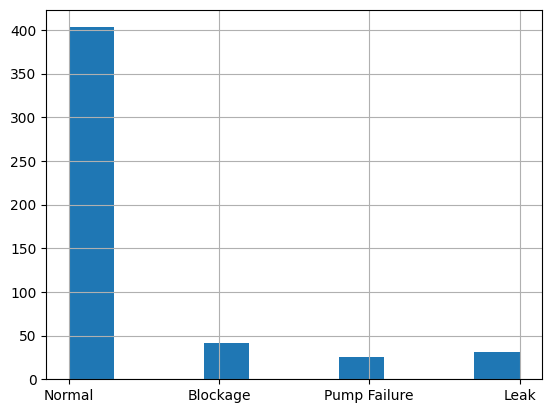

In [11]:
df.Event_Type.hist()

## 3. Transformaciones (Encoding, Imputación)

In [12]:
df.isnull().sum()

Well_ID                 25
Date                    25
Time                    25
Pressure                25
Temperature             25
Flow_Rate               25
Pump_Speed              25
Gas_Oil_Ratio           25
Water_Cut               25
Vibration               25
Event_Type               0
Maintenance_Required    25
Downtime                25
dtype: int64

In [13]:
df.Temperature.describe()

count    475.000000
mean     202.865593
std       56.146715
min      100.270725
25%      153.730480
50%      204.310197
75%      251.558604
max      299.361836
Name: Temperature, dtype: float64

<Axes: >

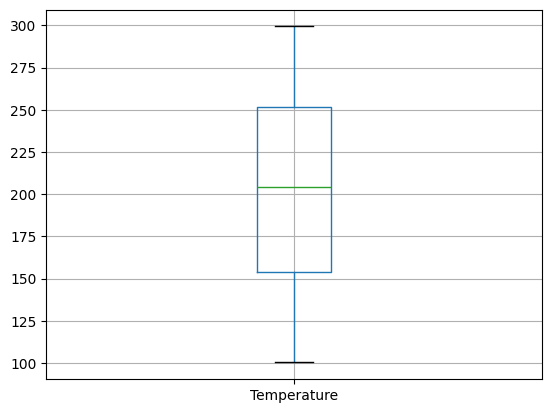

In [14]:
df.Temperature.to_frame().boxplot()

In [15]:
# Método de Imputación "Simple"
# Cuando tenemos pocas variables podemos completar el valor faltante con una medida de tendencia central, como la media
df.Temperature.fillna(df.Temperature.mean())
df.Pressure.fillna(df.Pressure.mean())

0      3394.633937
1      1003.115063
2      3056.937754
3      1964.101864
4      1125.253170
          ...     
495    1224.855622
496    1870.915599
497    4580.306237
498    3258.376325
499    1760.911723
Name: Pressure, Length: 500, dtype: float64

In [16]:
from sklearn.preprocessing import LabelEncoder

In [17]:
label_encoder = LabelEncoder()

# Crear una columna de tipo numérica que va a asignar un número con base a Event_Type
df['Event_Type_n'] = label_encoder.fit_transform(df.Event_Type)

df[["Event_Type_n","Event_Type"]].value_counts()

Event_Type_n  Event_Type  
2             Normal          403
0             Blockage         41
1             Leak             31
3             Pump Failure     25
Name: count, dtype: int64

In [18]:
# Diccionario Manual para hacer la codificacion
manual_encode = {
    "Normal" : 0,
    "Blockage" : 1,
    "Leak" : 2,
    "Pump Failure": 3
}

df.Event_Type.map(manual_encode)

0      0
1      0
2      1
3      0
4      0
      ..
495    0
496    0
497    0
498    1
499    0
Name: Event_Type, Length: 500, dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Well_ID               475 non-null    float64
 1   Date                  475 non-null    object 
 2   Time                  475 non-null    object 
 3   Pressure              475 non-null    float64
 4   Temperature           475 non-null    float64
 5   Flow_Rate             475 non-null    float64
 6   Pump_Speed            475 non-null    float64
 7   Gas_Oil_Ratio         475 non-null    float64
 8   Water_Cut             475 non-null    float64
 9   Vibration             475 non-null    float64
 10  Event_Type            500 non-null    object 
 11  Maintenance_Required  475 non-null    float64
 12  Downtime              475 non-null    float64
 13  Event_Type_n          500 non-null    int64  
dtypes: float64(10), int64(1), object(3)
memory usage: 54.8+ KB


In [20]:
# Instrucción para descartar columnas que no sean numéricas
# Y aparte renombra la columna codificada por el nombre original
df_encoded = df.select_dtypes(exclude=['object']).rename(columns={"Event_Type_n":"Event_Type"})

In [21]:
df_encoded

,Well_ID,Pressure,Temperature,Flow_Rate,Pump_Speed,Gas_Oil_Ratio,Water_Cut,Vibration,Maintenance_Required,Downtime,Event_Type
0,7.0,3394.633937,131.203728,155.994520,174.250837,1326.028990,0.601115,7.080726,0.0,0.000000,2
1,2.0,1003.115063,298.442312,617.481510,1834.959481,NaN,0.023062,5.247747,0.0,0.000000,2
2,16.0,3056.937754,218.482914,46.450413,1822.634556,421.681361,NaN,9.488855,1.0,59.737430,0
3,9.0,1964.101864,236.652704,609.996658,2499.584735,425.374050,0.391061,1.822361,0.0,0.000000,2
4,6.0,1125.253170,268.456955,449.754133,1185.450708,1404.656526,0.727272,3.265408,0.0,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...
495,2.0,1224.855622,249.504127,850.852757,858.405127,1032.581456,0.314162,9.579711,0.0,0.000000,2
496,9.0,1870.915599,224.245306,48.078968,1450.723757,219.041265,0.921144,9.760860,0.0,0.000000,2
497,8.0,4580.306237,214.785827,350.777623,2498.081239,841.428711,0.911633,9.280142,0.0,0.000000,2
498,11.0,3258.376325,150.464549,915.289940,797.056695,1364.560451,NaN,6.565627,1.0,18.799964,0


In [22]:
# Carga de librería de SimpleImputer
from sklearn.impute import SimpleImputer

In [23]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Well_ID               475 non-null    float64
 1   Pressure              475 non-null    float64
 2   Temperature           475 non-null    float64
 3   Flow_Rate             475 non-null    float64
 4   Pump_Speed            475 non-null    float64
 5   Gas_Oil_Ratio         475 non-null    float64
 6   Water_Cut             475 non-null    float64
 7   Vibration             475 non-null    float64
 8   Maintenance_Required  475 non-null    float64
 9   Downtime              475 non-null    float64
 10  Event_Type            500 non-null    int64  
dtypes: float64(10), int64(1)
memory usage: 43.1 KB


In [24]:
imputer = SimpleImputer(strategy="mean")

df_imputado = pd.DataFrame( imputer.fit_transform(df_encoded), columns= df_encoded.columns  )

In [25]:
"""
Event_Type_n  Event_Type  
2             Normal          403
0             Blockage         41
1             Leak             31
3             Pump Failure     25
Name: count, dtype: int64
"""

'\nEvent_Type_n  Event_Type  \n2             Normal          403\n0             Blockage         41\n1             Leak             31\n3             Pump Failure     25\nName: count, dtype: int64\n'

In [26]:
df_imputado

,Well_ID,Pressure,Temperature,Flow_Rate,Pump_Speed,Gas_Oil_Ratio,Water_Cut,Vibration,Maintenance_Required,Downtime,Event_Type
0,7.0,3394.633937,131.203728,155.994520,174.250837,1326.028990,0.601115,7.080726,0.0,0.000000,2.0
1,2.0,1003.115063,298.442312,617.481510,1834.959481,826.067573,0.023062,5.247747,0.0,0.000000,2.0
2,16.0,3056.937754,218.482914,46.450413,1822.634556,421.681361,0.517296,9.488855,1.0,59.737430,0.0
3,9.0,1964.101864,236.652704,609.996658,2499.584735,425.374050,0.391061,1.822361,0.0,0.000000,2.0
4,6.0,1125.253170,268.456955,449.754133,1185.450708,1404.656526,0.727272,3.265408,0.0,0.000000,2.0
...,...,...,...,...,...,...,...,...,...,...,...
495,2.0,1224.855622,249.504127,850.852757,858.405127,1032.581456,0.314162,9.579711,0.0,0.000000,2.0
496,9.0,1870.915599,224.245306,48.078968,1450.723757,219.041265,0.921144,9.760860,0.0,0.000000,2.0
497,8.0,4580.306237,214.785827,350.777623,2498.081239,841.428711,0.911633,9.280142,0.0,0.000000,2.0
498,11.0,3258.376325,150.464549,915.289940,797.056695,1364.560451,0.517296,6.565627,1.0,18.799964,0.0


In [27]:
df_imputado.Event_Type.value_counts()

Event_Type
2.0    403
0.0     41
1.0     31
3.0     25
Name: count, dtype: int64

In [28]:
# Regla de balanceo de clases
(41+31+25)/3 * 1.1

35.56666666666667

In [29]:
majority_class_df_sample = df_imputado.loc[ df_imputado.Event_Type == 2 ].sample(35)

In [30]:
df_imputado.loc[ df_imputado.Event_Type == 2 ].describe()

,Well_ID,Pressure,Temperature,Flow_Rate,Pump_Speed,Gas_Oil_Ratio,Water_Cut,Vibration,Maintenance_Required,Downtime,Event_Type
count,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.0
mean,10.420170,2942.621347,202.557660,488.745052,1501.895679,831.211214,0.523728,4.662769,0.009612,0.458116,2.0
std,5.704338,1157.050270,54.862889,277.016238,827.785615,356.558956,0.283777,2.784483,0.042116,2.062073,0.0
min,1.000000,1001.771126,101.810832,0.011635,3.088440,204.183743,0.001992,0.031409,0.000000,0.000000,2.0
25%,6.000000,1920.023988,158.692183,260.185968,780.150099,551.626912,0.299550,2.131812,0.000000,0.000000,2.0
50%,10.362105,2960.284279,202.865593,490.951223,1498.645006,826.067573,0.517296,4.767155,0.000000,0.000000,2.0
75%,15.000000,3955.884754,248.920758,699.242711,2172.211041,1110.742217,0.752962,6.796059,0.000000,0.000000,2.0
max,20.000000,4990.997556,299.361836,995.734452,2999.141412,1495.535353,0.997518,9.963343,0.193684,9.716888,2.0


In [31]:
majority_class_df_sample.describe()

,Well_ID,Pressure,Temperature,Flow_Rate,Pump_Speed,Gas_Oil_Ratio,Water_Cut,Vibration,Maintenance_Required,Downtime,Event_Type
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.0
mean,10.859609,2867.077509,189.612712,528.810495,1630.718818,791.688706,0.506573,4.157563,0.011068,0.277625,2.0
std,5.809553,907.871756,54.297260,252.893941,806.525126,310.138255,0.311724,2.427562,0.045613,1.642454,0.0
min,1.000000,1054.687859,106.223120,19.192277,47.469516,233.002262,0.003817,0.110786,0.000000,0.000000,2.0
25%,6.000000,2179.976707,144.524150,379.518618,1019.066761,597.282679,0.260136,1.964491,0.000000,0.000000,2.0
50%,10.362105,3049.830624,196.268830,509.724247,1751.318342,795.009487,0.470867,4.217039,0.000000,0.000000,2.0
75%,16.000000,3421.584355,227.419386,719.070294,2337.729127,1022.431147,0.811263,5.731965,0.000000,0.000000,2.0
max,20.000000,4570.235994,296.795530,969.536867,2724.055636,1437.888321,0.994082,8.733367,0.193684,9.716888,2.0


In [32]:
majority_class_df_sample

,Well_ID,Pressure,Temperature,Flow_Rate,Pump_Speed,Gas_Oil_Ratio,Water_Cut,Vibration,Maintenance_Required,Downtime,Event_Type
371,14.000000,3201.887108,258.002968,490.951223,1739.193498,649.312492,0.815769,4.667281,0.000000,0.000000,2.0
424,1.000000,2910.968506,195.631785,767.969978,1885.699202,1023.242162,0.450282,5.311095,0.000000,0.000000,2.0
83,10.362105,3952.134466,202.865593,603.152109,736.047329,706.084298,0.288694,3.556727,0.000000,0.000000,2.0
113,20.000000,3643.280473,210.600291,490.951223,2351.497660,825.174981,0.040754,1.639995,0.000000,0.000000,2.0
428,6.000000,1828.228334,208.794622,231.599025,2546.771608,716.452915,0.245551,8.123262,0.000000,0.000000,2.0
240,13.000000,3109.060724,281.284193,163.881024,1928.456744,1252.818244,0.947395,3.373401,0.000000,0.000000,2.0
117,4.000000,4493.692952,280.140373,421.720927,830.483392,826.067573,0.912363,2.106622,0.000000,0.000000,2.0
157,17.000000,2413.005634,159.307116,349.703230,2323.960594,1059.781794,0.517296,1.741093,0.000000,0.000000,2.0
408,3.000000,1567.977037,160.848373,139.246845,1836.025590,598.191296,0.326108,0.709160,0.000000,9.716888,2.0
137,17.000000,1920.984674,141.237233,637.960793,770.651543,1021.620132,0.058455,1.417744,0.000000,0.000000,2.0


In [33]:
minority_class_df_sample = df_imputado.loc[ df_imputado.Event_Type != 2]

In [34]:
minority_class_df_sample

,Well_ID,Pressure,Temperature,Flow_Rate,Pump_Speed,Gas_Oil_Ratio,Water_Cut,Vibration,Maintenance_Required,Downtime,Event_Type
2,16.0,3056.937754,218.482914,46.450413,1822.634556,421.681361,0.517296,9.488855,1.0,59.737430,0.0
8,15.0,1943.939679,151.213665,40.433590,2131.988669,344.158067,0.439337,2.017192,1.0,92.453312,3.0
9,4.0,2641.531692,251.110228,228.798165,230.939729,576.676889,0.161221,9.296977,1.0,31.869765,1.0
19,16.0,3170.160922,202.865593,636.332618,751.385456,966.832102,0.978893,4.867422,1.0,35.801239,0.0
30,10.0,4425.959365,231.738726,162.934427,211.706242,1035.145062,0.026511,5.857756,1.0,44.830347,0.0
...,...,...,...,...,...,...,...,...,...,...,...
477,6.0,4200.550331,148.331784,490.951223,950.712413,546.832914,0.505926,7.777279,1.0,145.660428,3.0
481,13.0,1727.054391,200.826568,322.809793,774.322930,803.181043,0.133284,9.277457,1.0,125.897364,3.0
485,7.0,2546.785800,264.228485,969.490899,1361.778409,859.099506,0.572172,9.323481,1.0,48.566562,3.0
489,10.0,3861.289242,153.628646,315.668481,375.753693,1052.162963,0.039797,5.976823,1.0,152.279829,3.0


In [35]:
df_balanced = pd.concat([ majority_class_df_sample, minority_class_df_sample])

In [36]:
df_balanced.Event_Type.value_counts()

Event_Type
0.0    41
2.0    35
1.0    31
3.0    25
Name: count, dtype: int64

## 4. Modelamiento

In [37]:
# Carga de librerías para modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


In [38]:
X = df_balanced.drop(columns=["Event_Type"])
y = df_balanced.Event_Type
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size= 0.8, random_state=23)

In [39]:
model_dtc = DecisionTreeClassifier()
model_dtc.fit(X_train,y_train)

DecisionTreeClassifier()

In [40]:
model_knc = KNeighborsClassifier()
model_knc.fit(X_train,y_train)

KNeighborsClassifier()

In [41]:
model_svc = SVC()
model_svc.fit(X_train,y_train)

SVC()

# Sesión 07 - 5.  Evaluación

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

In [43]:
predict_dtc = model_dtc.predict(X_test)
predict_knc = model_knc.predict(X_test)
predict_svc = model_svc.predict(X_test)

In [44]:
def eval_model(y_pred,y_test):
    metrics = {
        'accuracy': accuracy_score(y_pred= y_pred, y_true=y_test),
        'precision': precision_score(y_pred= y_pred, y_true=y_test,average='weighted'),
        'recall': recall_score(y_pred= y_pred, y_true=y_test,average='weighted'),
        'F1-score' : f1_score(y_pred= y_pred, y_true=y_test,average='weighted') 

    }
    return metrics

In [45]:
eval_model(predict_dtc,y_test)

{'accuracy': 0.6666666666666666,
 'precision': 0.7746913580246914,
 'recall': 0.6666666666666666,
 'F1-score': 0.6567901234567901}

In [46]:
eval_model(predict_knc,y_test)

{'accuracy': 0.3333333333333333,
 'precision': 0.3851851851851852,
 'recall': 0.3333333333333333,
 'F1-score': 0.35143414090782515}

In [47]:
eval_model(predict_svc,y_test)

{'accuracy': 0.2962962962962963,
 'precision': 0.6703703703703704,
 'recall': 0.2962962962962963,
 'F1-score': 0.30987993487993487}

In [48]:
print(classification_report(y_true= y_test, y_pred=predict_dtc))

              precision    recall  f1-score   support

         0.0       0.75      0.27      0.40        11
         1.0       0.33      0.67      0.44         3
         2.0       1.00      1.00      1.00        11
         3.0       0.33      1.00      0.50         2

    accuracy                           0.67        27
   macro avg       0.60      0.73      0.59        27
weighted avg       0.77      0.67      0.66        27



In [49]:

models = {
    'KNN': model_knc,
    'DTC': model_dtc,
    'SVC': model_svc
}

def compare_models(models, X_test, y_test):
    result = []
    i = 0
    for name, model in models.items():
        y_predict = model.predict(X_test)
        metrics = eval_model(y_predict,y_test)
        metrics['name'] = name
        print(metrics)
        metrics_df = pd.DataFrame(data=metrics,index=[i])
        print(metrics_df)
        result.append(metrics_df)
        i += 1 

    return pd.concat(result).reindex()
        

In [50]:
compare_models(models,X_test,y_test)

{'accuracy': 0.3333333333333333, 'precision': 0.3851851851851852, 'recall': 0.3333333333333333, 'F1-score': 0.35143414090782515, 'name': 'KNN'}
   accuracy  precision    recall  F1-score name
0  0.333333   0.385185  0.333333  0.351434  KNN
{'accuracy': 0.6666666666666666, 'precision': 0.7746913580246914, 'recall': 0.6666666666666666, 'F1-score': 0.6567901234567901, 'name': 'DTC'}
   accuracy  precision    recall  F1-score name
1  0.666667   0.774691  0.666667   0.65679  DTC
{'accuracy': 0.2962962962962963, 'precision': 0.6703703703703704, 'recall': 0.2962962962962963, 'F1-score': 0.30987993487993487, 'name': 'SVC'}
   accuracy  precision    recall  F1-score name
2  0.296296    0.67037  0.296296   0.30988  SVC


,accuracy,precision,recall,F1-score,name
0,0.333333,0.385185,0.333333,0.351434,KNN
1,0.666667,0.774691,0.666667,0.656790,DTC
2,0.296296,0.670370,0.296296,0.309880,SVC


In [51]:
from sklearn.tree import plot_tree

In [52]:
feature_names = X_test.columns.to_list()

In [53]:
class_names = [str(i) for i in y_test.unique()]

In [54]:
df['Event_Type'].unique().tolist()

['Normal', 'Blockage', 'Pump Failure', 'Leak']

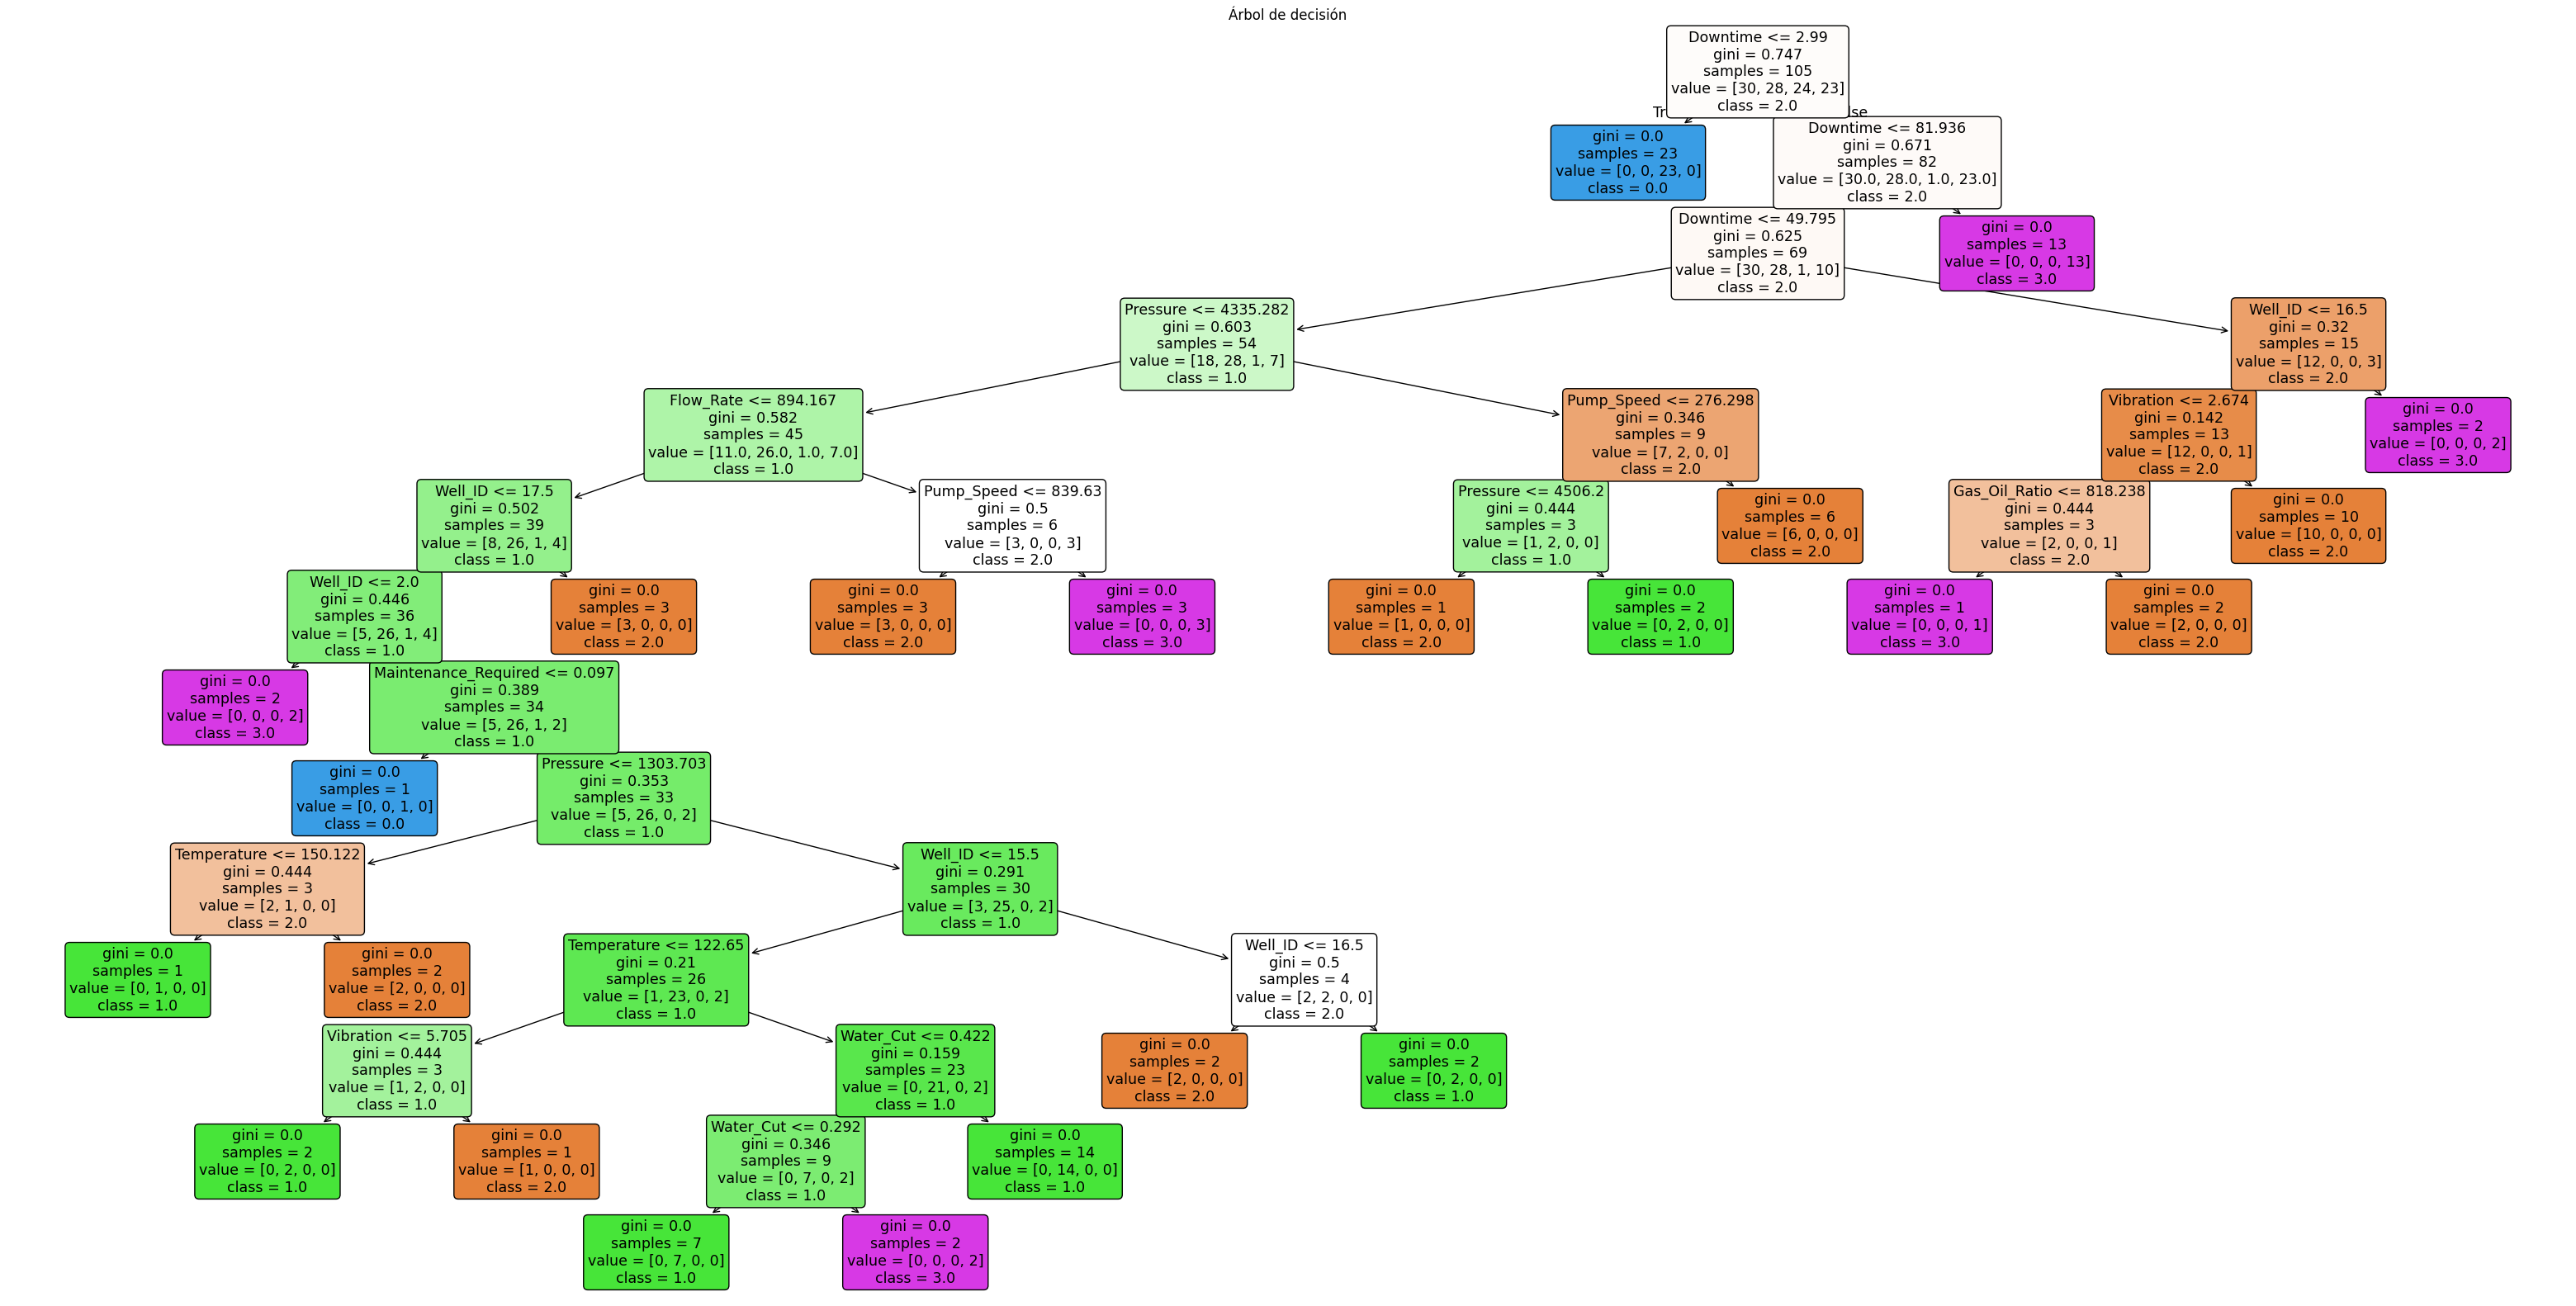

In [55]:
plt.figure(figsize=(40,20))
plot_tree(
    decision_tree=model_dtc,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True
)
plt.title('Árbol de decisión')
plt.show()
plt.close()

In [56]:
from sklearn.metrics import pairwise_distances

In [57]:
X_test

,Well_ID,Pressure,Temperature,Flow_Rate,Pump_Speed,Gas_Oil_Ratio,Water_Cut,Vibration,Maintenance_Required,Downtime
375,3.000000,3161.115573,115.856057,565.850560,2724.055636,715.206413,0.296326,1.434695,0.0,0.000000
114,18.000000,2917.115714,223.148404,329.017438,1410.547778,1167.562785,0.871833,4.336553,0.0,0.000000
113,20.000000,3643.280473,210.600291,490.951223,2351.497660,825.174981,0.040754,1.639995,0.0,0.000000
3,9.000000,1964.101864,236.652704,609.996658,2499.584735,425.374050,0.391061,1.822361,0.0,0.000000
418,15.000000,1895.698351,172.654559,438.647500,2932.488775,1250.225339,0.737410,5.370413,1.0,9.716888
267,7.000000,2960.284279,118.413397,599.044587,1870.946335,1043.056266,0.267402,0.151107,1.0,24.057155
69,4.000000,3605.468844,254.249334,374.435370,206.764618,300.517385,0.104247,8.404396,1.0,15.859890
410,1.000000,2376.366471,204.108767,440.664883,2639.743880,826.067573,0.507758,1.383716,1.0,23.998265
83,10.362105,3952.134466,202.865593,603.152109,736.047329,706.084298,0.288694,3.556727,0.0,0.000000
311,17.000000,2582.831854,243.037291,281.919043,1091.428923,447.943784,0.347062,5.472375,1.0,50.508910


In [58]:
pairwise_distances(X_test.head(1), X_test.tail(1) )

array([[2438.85836409]])

<Axes: title={'center': 'KNN'}>

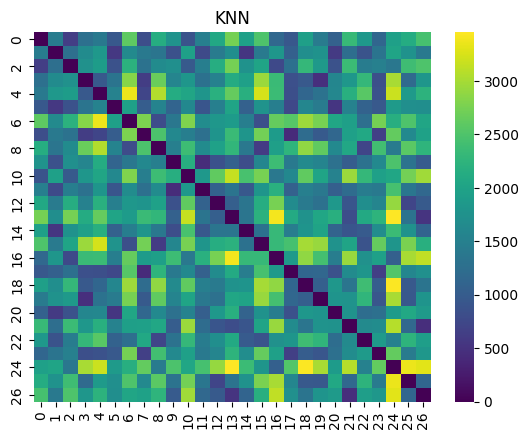

In [59]:
distances = pairwise_distances(X_test)
plt.title('KNN')
sns.heatmap(distances,cmap='viridis')

In [60]:
X_test

,Well_ID,Pressure,Temperature,Flow_Rate,Pump_Speed,Gas_Oil_Ratio,Water_Cut,Vibration,Maintenance_Required,Downtime
375,3.000000,3161.115573,115.856057,565.850560,2724.055636,715.206413,0.296326,1.434695,0.0,0.000000
114,18.000000,2917.115714,223.148404,329.017438,1410.547778,1167.562785,0.871833,4.336553,0.0,0.000000
113,20.000000,3643.280473,210.600291,490.951223,2351.497660,825.174981,0.040754,1.639995,0.0,0.000000
3,9.000000,1964.101864,236.652704,609.996658,2499.584735,425.374050,0.391061,1.822361,0.0,0.000000
418,15.000000,1895.698351,172.654559,438.647500,2932.488775,1250.225339,0.737410,5.370413,1.0,9.716888
267,7.000000,2960.284279,118.413397,599.044587,1870.946335,1043.056266,0.267402,0.151107,1.0,24.057155
69,4.000000,3605.468844,254.249334,374.435370,206.764618,300.517385,0.104247,8.404396,1.0,15.859890
410,1.000000,2376.366471,204.108767,440.664883,2639.743880,826.067573,0.507758,1.383716,1.0,23.998265
83,10.362105,3952.134466,202.865593,603.152109,736.047329,706.084298,0.288694,3.556727,0.0,0.000000
311,17.000000,2582.831854,243.037291,281.919043,1091.428923,447.943784,0.347062,5.472375,1.0,50.508910


In [61]:
print(dtc_accuracy)
print(dtc_precision)
print(dtc_recall)
print(dtc_f1)

NameError: name 'dtc_accuracy' is not defined

In [ ]:
dtc_cmatrix

array([[ 1,  2,  0,  1],
       [ 4,  2,  0,  0],
       [ 0,  0, 87,  0],
       [ 1,  1,  0,  1]])

In [ ]:
dtc_cmatrix

array([[ 4,  3,  0,  4],
       [ 1,  2,  0,  0],
       [ 0,  0, 11,  0],
       [ 0,  0,  0,  2]])

In [ ]:
confusion_matrix(y_pred= predict_knc, y_true= y_test)

array([[5, 3, 1, 2],
       [1, 1, 1, 0],
       [3, 4, 3, 1],
       [1, 0, 1, 0]])

In [ ]:
confusion_matrix(y_pred= predict_svc, y_true= y_test)

array([[3, 7, 0, 1],
       [0, 3, 0, 0],
       [1, 7, 0, 3],
       [1, 1, 0, 0]])